# Extracting Period Information

In this tutorial, we will go through
- loading variable star data using Astropy
- extracting period information using the Lomb-Scargle Periodogram
- looking at where variables lie in the HR diagram
- making a period-luminosity relation

First, let's load all the Python packages we'll need.

In [31]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import os

from astropy.timeseries import LombScargle
from astropy.table import Table

# configure notebook for plotting
%pylab inline --no-import-all 
mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color'] # allows access to colours
# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Load some data

Let's pick a data directory from files I prepared earlier. These were from an earlier run of the universe-making code and don't belong to any group in this project!

In [12]:
ddir = '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/'

What's in the directory?

In [55]:
ls /Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/

P00119.csv   P01479.png   P02770.csv   P04011.png   P04549.csv   index.html
P00119.png   P01813.csv   P02770.png   P04153.csv   P04549.png   indexim.png
P01247.csv   P01813.png   P02893.csv   P04153.png   P04693.csv   points.txt
P01247.png   P01995.csv   P02893.png   P04290.csv   P04693.png
P01252.csv   P01995.png   P03630.csv   P04290.png   P05336.csv
P01252.png   P02520.csv   P03630.png   P04327.csv   P05336.png
P01479.csv   P02520.png   P04011.csv   P04327.png   fuzzy.txt


Let's pick and load a single .csv file of a light curve. In this tutorial we'll use Astropy, a standard Python library for astronomical data; if you know Pandas, this is more common in data science and has similar functionality. Use whatever you like! 

We're first going to calculate the Nyquist limit - you can't pick out a period shorter than twice the rate at which you get time samples. As these data are hourly, it means we can't measure periods shorter than 2 hours. Because it's linear in Fourier space, we'll usually work in *frequency* rather than period, but use whichever you wish - so long as you're careful!

In [56]:
fname = 'P04327.csv'

data = Table.read(ddir+fname,format='ascii') # load in CSV data as an astropy Table object
time, flux = data['Time'], data['Flux'] # just extract the columns as variables
dt = np.median(np.diff(time))
print('Nyquist Limit',0.5/dt,'cycles per hour') # can't get frequencies higher than the Nyquist limit

Nyquist Limit 0.5 cycles per hour


Text(0, 0.5, 'Relative Flux')

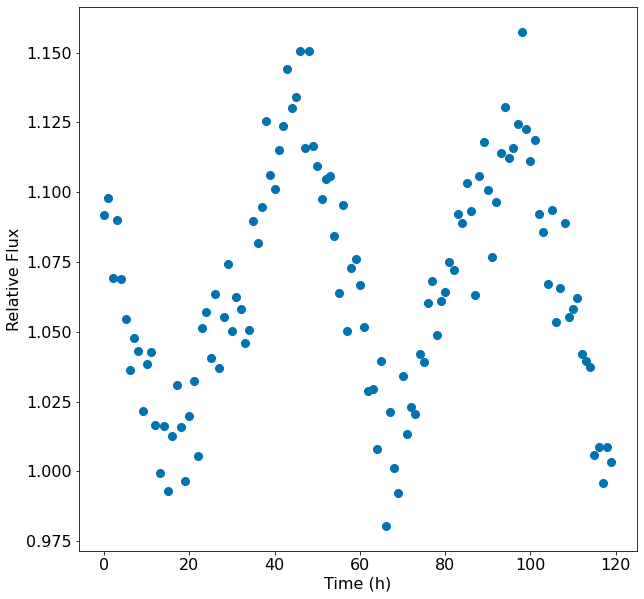

In [58]:
plt.plot(time,flux,'.',markersize=16)
plt.xlabel('Time (h)')
plt.ylabel('Relative Flux')

## Lomb-Scargle Periodograms

The Lomb-Scargle periodogram is named because it was first used in the PhD thesis of the former director of Sydney Observatory, Nick Lomb. It is probably the most widely cited Australian astronomy paper! If you want to determine the periodic content (Fourier power spectrum) of a time series - including if it is sparsely or irregularly sampled - it is the algorithm to go to. Rather than using the Fast Fourier Transform, the LS periodogram simply does a least squares fit against sines and cosines - this can be done very fast, and applied to nonuniform data. 

In [16]:
LS = LombScargle(time,flux) # initialize a Lomb-Scargle algorithm from Astropy
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
power = LS.power(freqs) # calculate LS power 


In [61]:
print('Best period: %.2f h' % (1/freqs[np.argmax(power)]))

Best period: 53.19 h


Text(0, 0.5, 'LS Power')

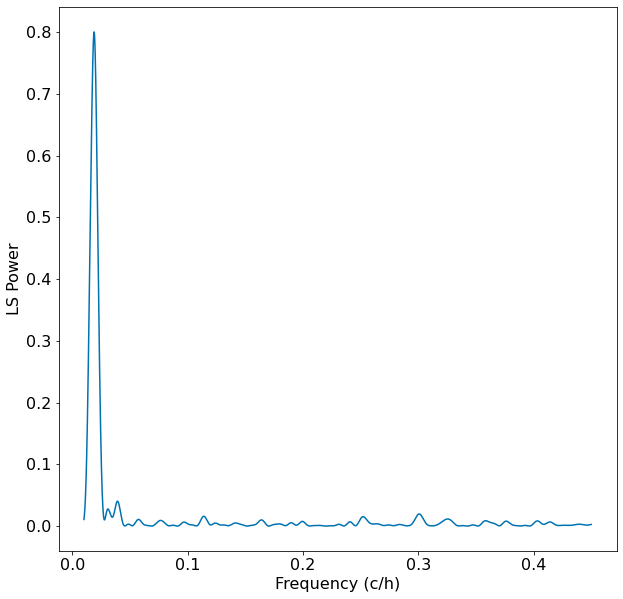

In [63]:
plt.plot(freqs,power)
plt.xlabel('Frequency (c/h)')
plt.ylabel('LS Power')

### Now let's loop over all the stars in the directory!

In [64]:
import glob # this package lets you search for filenames

fnames = glob.glob(ddir+'*.csv')
print(fnames)

['/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P01479.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P01247.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P01252.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P02770.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P02893.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P04011.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P04549.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P01813.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P03630.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P05336.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P02520.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P01995.csv', '/Users/benjaminpope/code/uqdistanceladder/data/U00/Down/B03/P04153.csv', '/Users/benjaminpope/code/uqdistancel

Below we are going to make plots of all these data - I encourage you to look at these, as you'll see that one dataset is too noisy, and we don't get a good sinusoidal fit to it. You can comment out the plotting code if you run it on lots of datasets though!

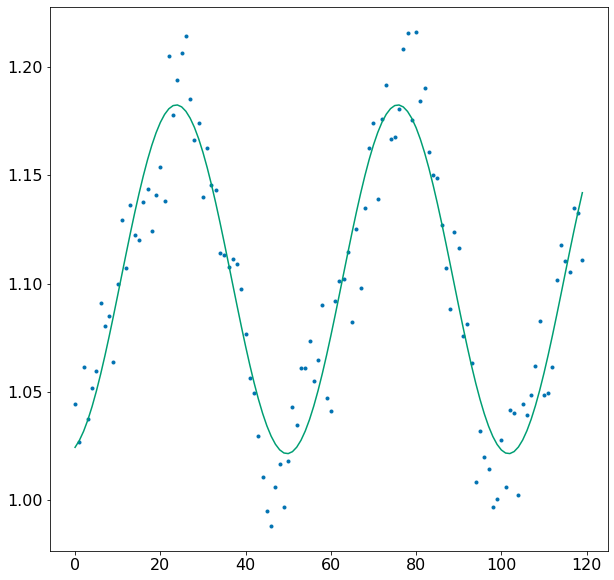

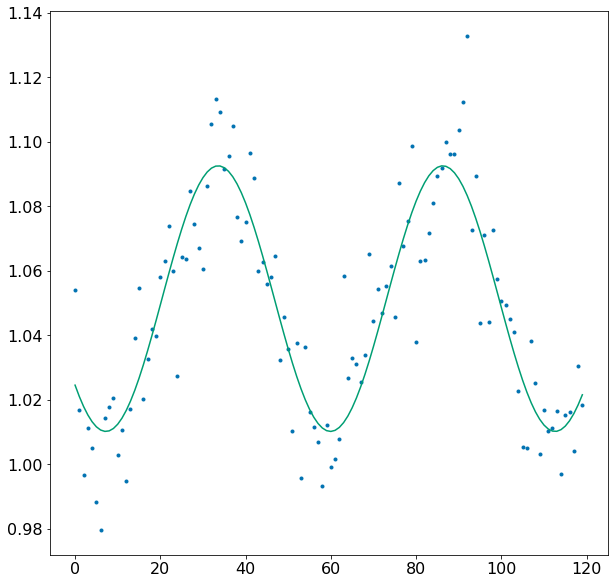

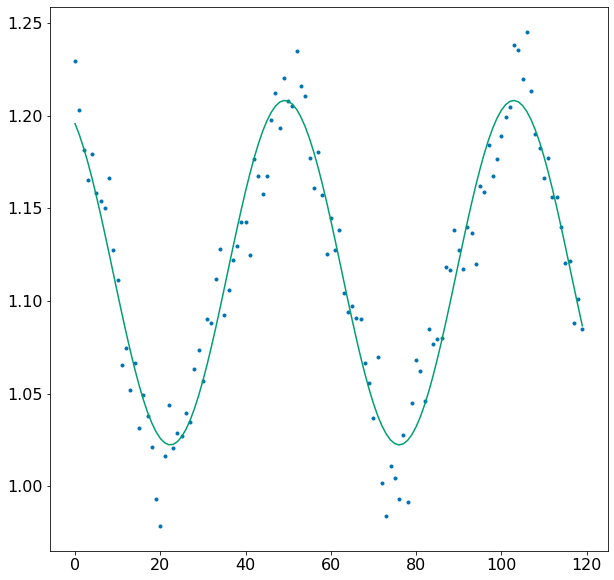

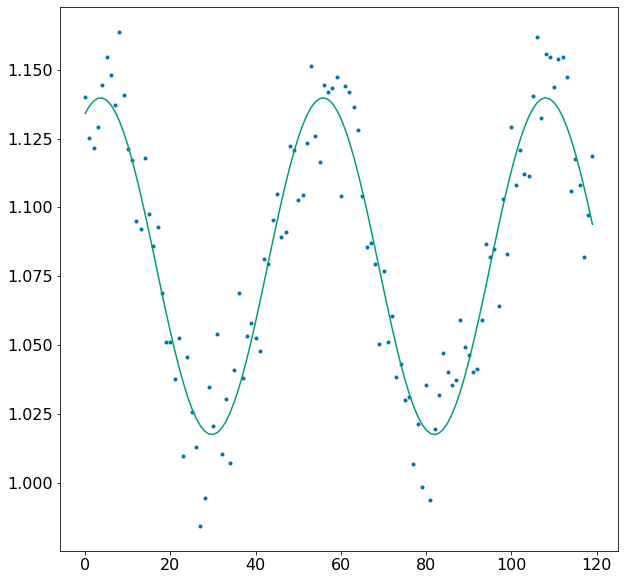

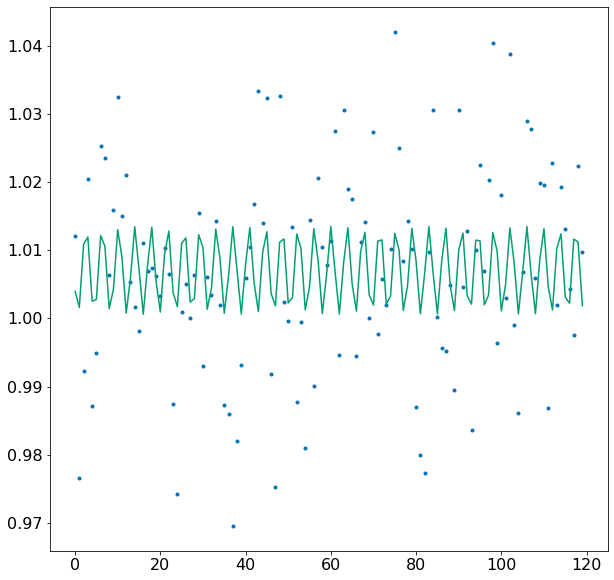

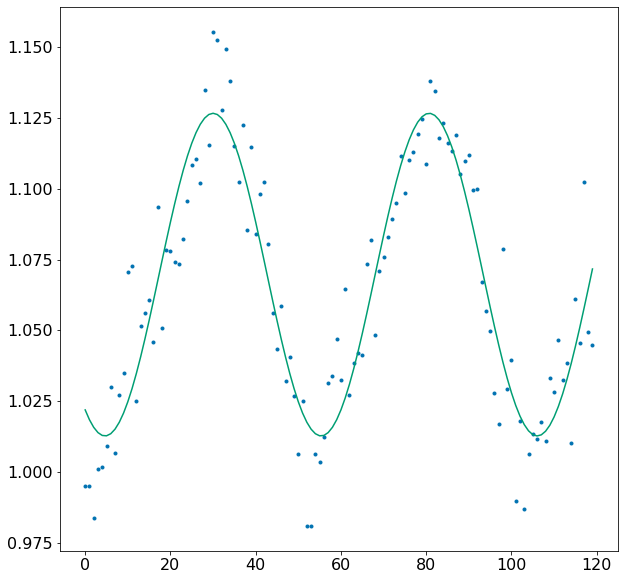

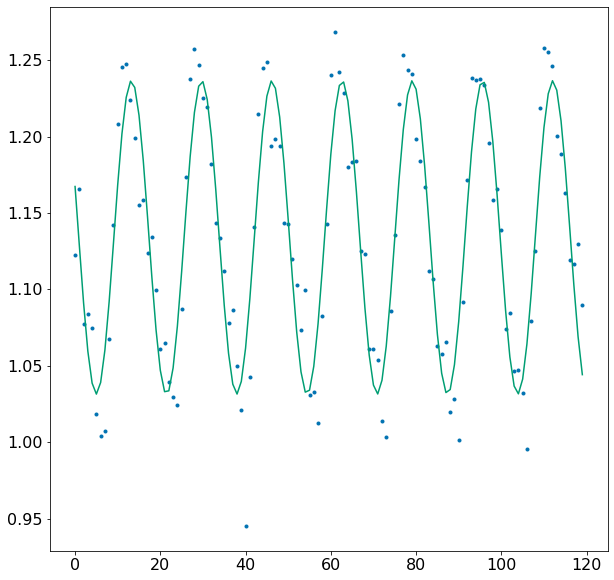

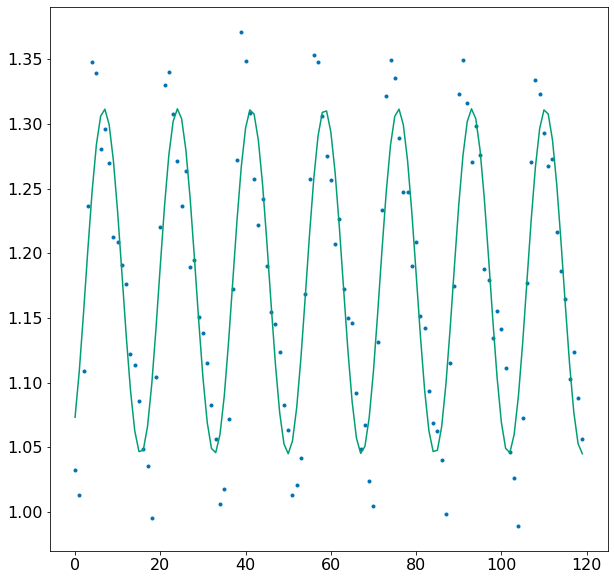

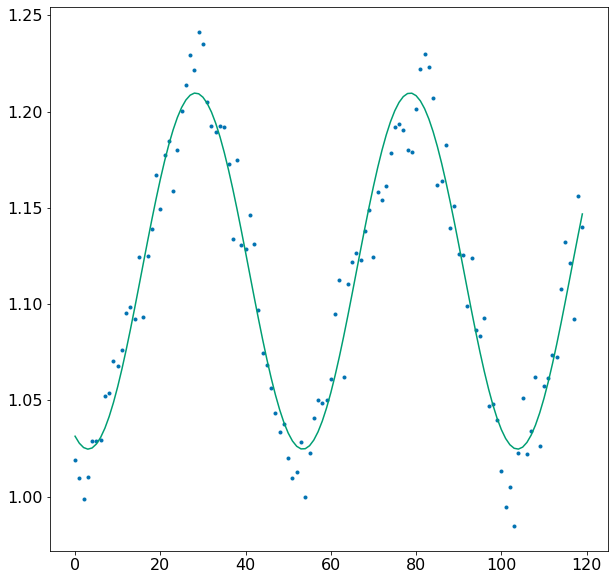

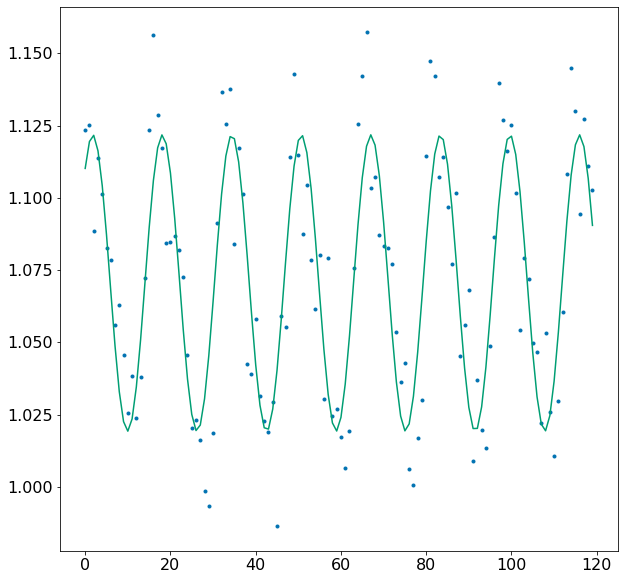

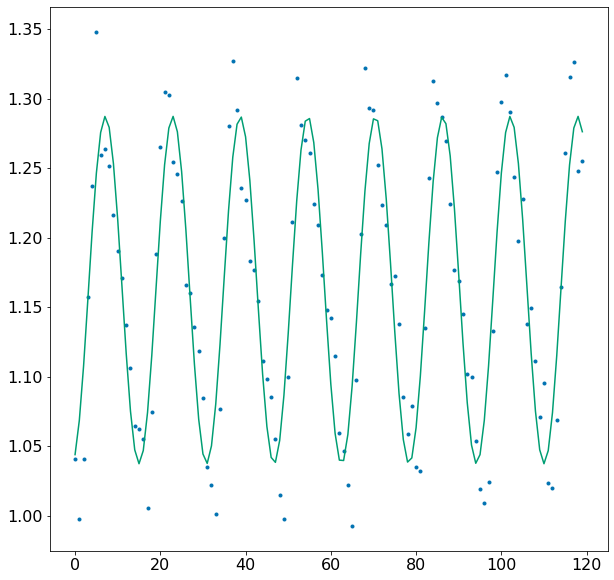

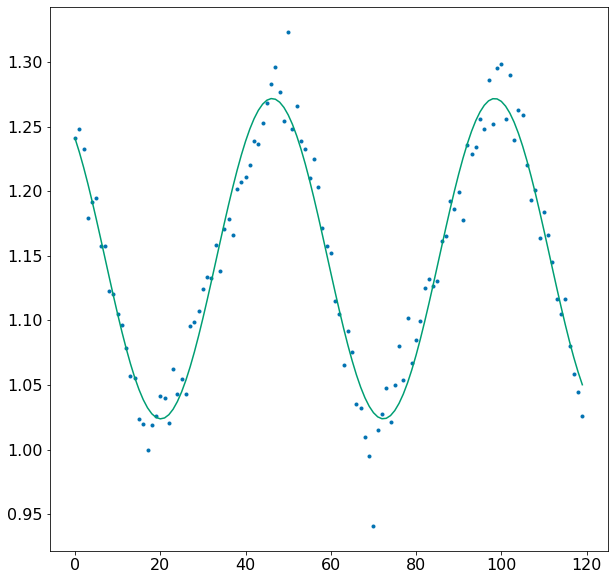

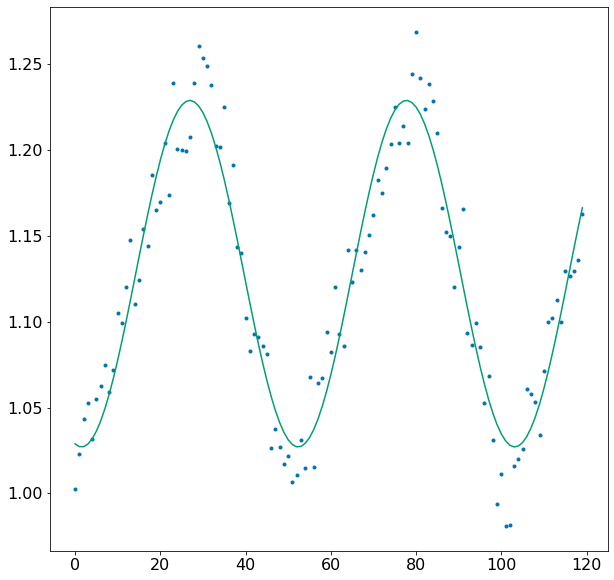

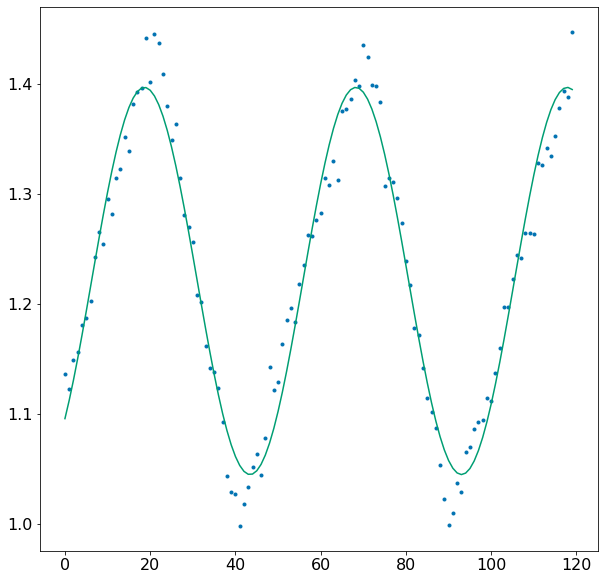

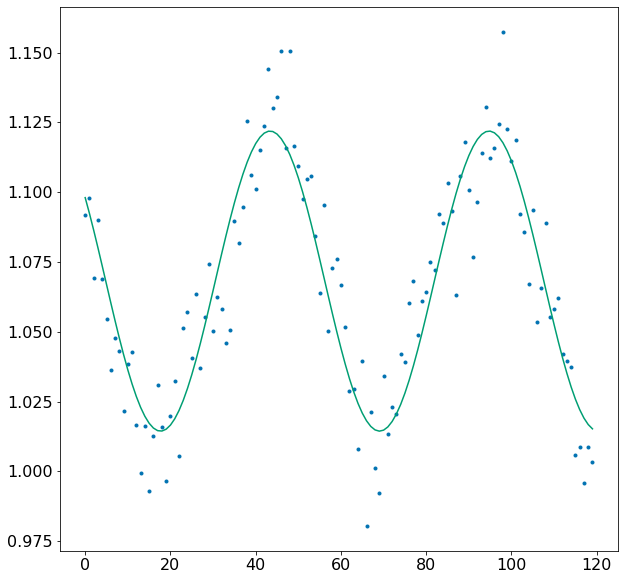

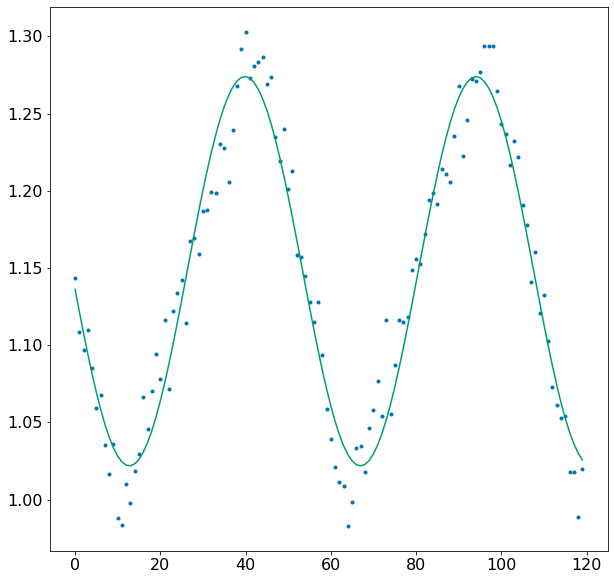

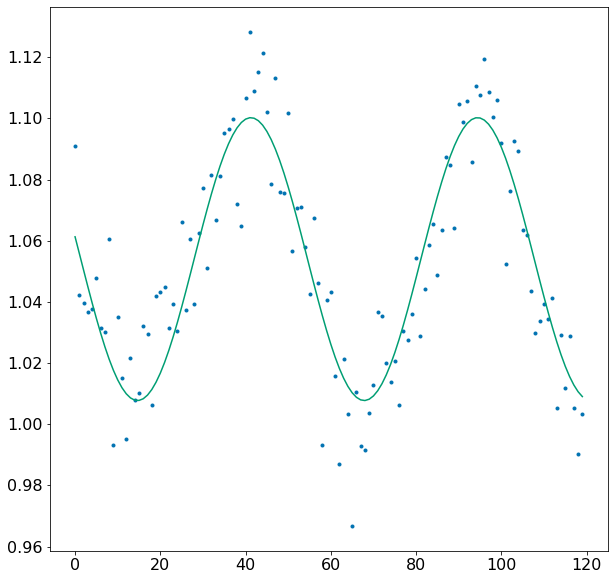

In [66]:
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
periods = [] # start an empty list to hold the period 

for fname in fnames:
    data = Table.read(fname,format='ascii') # load in CSV data as an astropy Table object
    time, flux = data['Time'], data['Flux'] # just extract the columns as variables

    LS = LombScargle(time,flux) # initialize a Lomb-Scargle
    power = LS.power(freqs) # calculate LS power 
    bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
    
    pred = LS.model(time,bestfreq) # make a sine wave prediction at the best frequency
    plt.plot(time,flux,'.')
    plt.plot(time,pred) # plot the model over the data
    plt.show()
     
    periods.append(1/bestfreq) # add each period to the list
    
periods = np.array(periods) # turn it from a list to an array

## HR Diagram and Period-Luminosity Relation

In [67]:
stars = Table.read(ddir+'points.txt',format='ascii')
variables = glob.glob(ddir+'*.csv')
varnames = [os.path.split(v)[-1].strip('.csv') for v in variables]

In [68]:
# because these are old data, they are formatted differently to the data you have
# so you can ignore this in your own analysis!
stars.rename_columns(['col1','col2','col3','col4','col5','col6','col7','col8'],
                     ['name','x', 'y', 'flux0', 'flux1', 'flux2', 'par', 'rv'])

Where do they lie on the sky? In a nice cluster! Perfect for making a period-luminosity diagram or HR diagram.

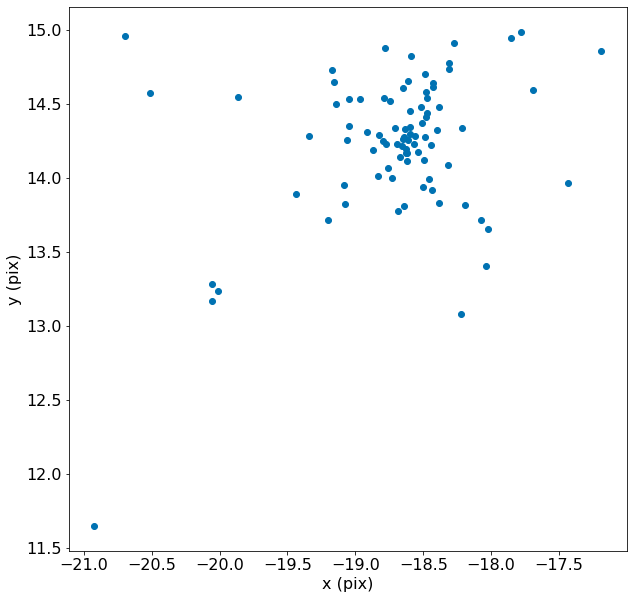

In [71]:
plt.scatter(stars['x'],stars['y'])
plt.xlabel('x (pix)')
plt.ylabel('y (pix)');

Let's make an HR diagram. One thing to keep in mind is that our convention of using magnitudes is just to match our modern scale to the Ancient Greeks - in your fantasy universe, you can use whatever units you like (but I recommend that they be logarithmic!). This is an important note - lots of students get hung up on the -2.5 and the solar luminosity, but these are just conventions in our world that aren't important for the physics.

So let's have a simple log scale for magnitude here.

In [73]:
m0, m1, m2 = np.log10(stars['flux0']), np.log10(stars['flux1']), np.log10(stars['flux2']) 
colour = m2-m0

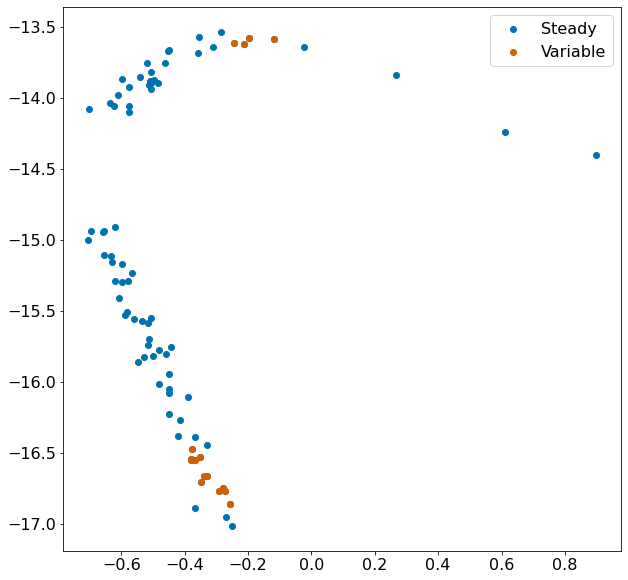

In [80]:
s = plt.scatter(colour,m1)
for var in varnames:
    mm = [stars['name']==var] # mask
    h = plt.scatter(colour[mm],m1[mm],color=colours[2])
    
plt.legend([s, h],['Steady','Variable'])

So we see there are two branches to this stellar population - a 'main sequence' to the lower left, and a giant branch to the top right. There are two sets of variables, one in each branch, with very different luminosities. Just like the real world!

### Period-Luminosity Diagram
Now let's make a period-luminosity diagram. Can we distinguish these stars by period, and anchor the distance ladder?

In [81]:
absmag = []
for var in varnames:
    mm = [stars['name']==var] # mask
    absmag.append(m1[mm])
absmag = np.array(absmag)

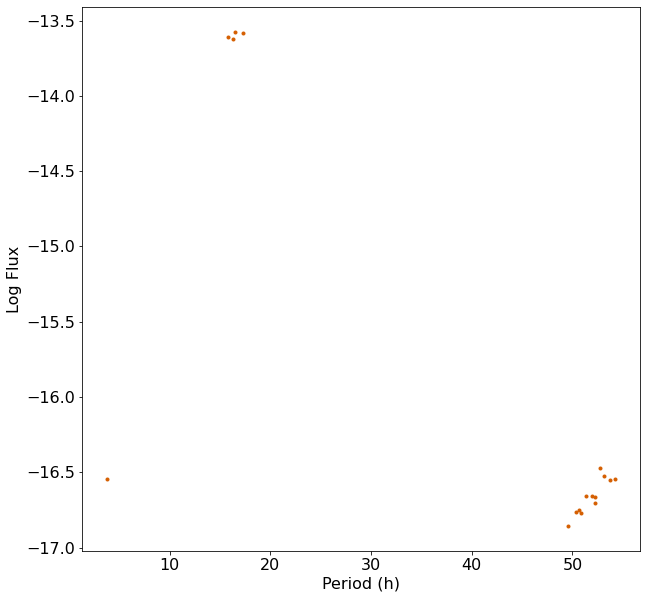

In [85]:
plt.plot(periods,absmag,'.',color=colours[2])
plt.xlabel('Period (h)')
plt.ylabel('Log Flux');

Yes we can! We see two kinds of star - with a short and a long period - and possibly a linear trend in the long period data. Will this pan out? You'll have to look at more data! And it could be *very* different in your own analysis - all these universes are generated with random, made-up (but consistent) stellar physics.